importing liberaries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, norm
from statsmodels.stats.weightstats import ztest
import seaborn as sns
import scipy.sparse

In [41]:
from sklearn.impute import SimpleImputer

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from sklearn.metrics import roc_curve, auc

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv('../data2/cleaned_data.csv', low_memory=False)
df

,Unnamed: 0,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000093,1000093,31520,389,2015-04-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000094,1000094,31520,389,2015-06-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000095,1000095,31520,389,2015-08-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000096,1000096,31519,389,2014-07-01 00:00:00,False,ZW,Individual,Mr,English,ABSA Bank,...,No excess,Passenger Liability,Passenger Liability,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,2.315000,0.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 51 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Unnamed: 0                1000098 non-null  int64  
 1   UnderwrittenCoverID       1000098 non-null  int64  
 2   PolicyID                  1000098 non-null  int64  
 3   TransactionMonth          1000098 non-null  object 
 4   IsVATRegistered           1000098 non-null  bool   
 5   Citizenship               1000098 non-null  object 
 6   LegalType                 1000098 non-null  object 
 7   Title                     1000098 non-null  object 
 8   Language                  1000098 non-null  object 
 9   Bank                      1000098 non-null  object 
 10  AccountType               1000098 non-null  object 
 11  MaritalStatus             1000098 non-null  object 
 12  Gender                    1000098 non-null  object 
 13  Country                   1

In [47]:
df = df.dropna(subset=['TotalPremium', 'TotalClaims', 'Province'])

In [49]:
import pandas as pd
import numpy as np


# 1. Create Ratios and Differences
df['Claims_to_Premium_Ratio'] = df['TotalClaims'] / (df['TotalPremium'] + 1e-6)  # Avoid division by zero
df['Premium_minus_Claims'] = df['TotalPremium'] - df['TotalClaims']

# 2. Aggregate Features (e.g., Group by 'Province' and calculate mean TotalPremium and TotalClaims)
df['Province_Mean_Premium'] = df.groupby('Province')['TotalPremium'].transform('mean')
df['Province_Mean_Claims'] = df.groupby('Province')['TotalClaims'].transform('mean')

# 3. Binning (Categorizing 'TotalPremium' into bins)
df['Premium_Bin'] = pd.cut(df['TotalPremium'], bins=[0, 500, 1000, 5000, 10000, np.inf], 
                           labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 4. Date Features (e.g., extracting month and year from a 'TransactionMonth' column)
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])  
df['Transaction_Year'] = df['TransactionMonth'].dt.year
df['Transaction_Month'] = df['TransactionMonth'].dt.month

# 5. Polynomial Features (e.g., creating squared terms)
df['TotalPremium_Squared'] = df['TotalPremium'] ** 2
df['TotalClaims_Squared'] = df['TotalClaims'] ** 2

# 6. Interaction Features (e.g., multiplying relevant features)
df['Premium_Claims_Interaction'] = df['TotalPremium'] * df['TotalClaims']

# 7. Normalized Features (e.g., normalize TotalPremium and TotalClaims)
df['Normalized_Premium'] = (df['TotalPremium'] - df['TotalPremium'].mean()) / df['TotalPremium'].std()
df['Normalized_Claims'] = (df['TotalClaims'] - df['TotalClaims'].mean()) / df['TotalClaims'].std()

# Preview the new features
df

,Unnamed: 0,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,...,Province_Mean_Premium,Province_Mean_Claims,Premium_Bin,Transaction_Year,Transaction_Month,TotalPremium_Squared,TotalClaims_Squared,Premium_Claims_Interaction,Normalized_Premium,Normalized_Claims
0,0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,...,61.071115,74.630009,Very Low,2015,3,480.917205,0.0,0.0,-0.173593,-0.027206
1,1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,...,61.071115,74.630009,Very Low,2015,5,480.917205,0.0,0.0,-0.173593,-0.027206
2,2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,...,61.071115,74.630009,NaN,2015,7,0.000000,0.0,0.0,-0.268822,-0.027206
3,3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,...,61.071115,74.630009,Low,2015,5,263013.143083,0.0,0.0,1.958198,-0.027206
4,4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,...,61.071115,74.630009,NaN,2015,7,0.000000,0.0,0.0,-0.268822,-0.027206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000093,1000093,31520,389,2015-04-01,False,ZW,Individual,Mr,English,ABSA Bank,...,57.416793,60.831482,Very Low,2015,4,120572.267062,0.0,0.0,1.239031,-0.027206
1000094,1000094,31520,389,2015-06-01,False,ZW,Individual,Mr,English,ABSA Bank,...,57.416793,60.831482,Very Low,2015,6,120572.267062,0.0,0.0,1.239031,-0.027206
1000095,1000095,31520,389,2015-08-01,False,ZW,Individual,Mr,English,ABSA Bank,...,57.416793,60.831482,Very Low,2015,8,120572.267062,0.0,0.0,1.239031,-0.027206
1000096,1000096,31519,389,2014-07-01,False,ZW,Individual,Mr,English,ABSA Bank,...,57.416793,60.831482,Very Low,2014,7,5.359225,0.0,0.0,-0.258769,-0.027206


In [53]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns (object type)
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns

# Initialize the OneHotEncoder with sparse_output=True to avoid dense matrix conversion
encoder = OneHotEncoder(drop='first', sparse_output=True)

# Fit and transform the categorical columns
encoded_data_sparse = encoder.fit_transform(df[categorical_columns])

# Convert the sparse matrix into a DataFrame if needed (use with caution due to memory size)
# encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data_sparse, columns=encoder.get_feature_names_out(categorical_columns), index=df.index)

# Drop the original categorical columns and concatenate the encoded sparse matrix directly
df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, pd.DataFrame.sparse.from_spmatrix(encoded_data_sparse, columns=encoder.get_feature_names_out(categorical_columns), index=df.index)], axis=1)

In [54]:
df

,Unnamed: 0,UnderwrittenCoverID,PolicyID,TransactionMonth,PostalCode,mmcode,RegistrationYear,Cylinders,cubiccapacity,kilowatts,...,CoverGroup_Standalone passenger liability,CoverGroup_Third Party Only,CoverGroup_Trailer,Section_Motor Comprehensive,Section_Optional Extended Covers,Section_Standalone passenger liability,"Section_Third party or third party, fire and theft only",Product_Mobility Commercial Cover: Monthly,Product_Mobility Metered Taxis: Monthly,Product_Standalone Passenger Liability
0,0,145249,12827,2015-03-01,1459,44069150.0,2004,6.0,2597.0,130.0,...,0,0,0,1.0,0,0,0,0,1.0,0
1,1,145249,12827,2015-05-01,1459,44069150.0,2004,6.0,2597.0,130.0,...,0,0,0,1.0,0,0,0,0,1.0,0
2,2,145249,12827,2015-07-01,1459,44069150.0,2004,6.0,2597.0,130.0,...,0,0,0,1.0,0,0,0,0,1.0,0
3,3,145255,12827,2015-05-01,1459,44069150.0,2004,6.0,2597.0,130.0,...,0,0,0,1.0,0,0,0,0,1.0,0
4,4,145255,12827,2015-07-01,1459,44069150.0,2004,6.0,2597.0,130.0,...,0,0,0,1.0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000093,1000093,31520,389,2015-04-01,7493,4614100.0,2013,4.0,2693.0,110.0,...,0,0,0,1.0,0,0,0,1.0,0,0
1000094,1000094,31520,389,2015-06-01,7493,4614100.0,2013,4.0,2693.0,110.0,...,0,0,0,1.0,0,0,0,1.0,0,0
1000095,1000095,31520,389,2015-08-01,7493,4614100.0,2013,4.0,2693.0,110.0,...,0,0,0,1.0,0,0,0,1.0,0,0
1000096,1000096,31519,389,2014-07-01,7493,4614100.0,2013,4.0,2693.0,110.0,...,0,0,0,1.0,0,0,0,1.0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Columns: 1522 entries, Unnamed: 0 to Product_Standalone Passenger Liability
dtypes: Sparse[float64, 0](1507), float64(10), int64(5)
memory usage: 384.5 MB


In [10]:
from sklearn.preprocessing import Binarizer

target_column = 'TotalPremium'  

# Binarizing the target variable
# Assuming you want to classify values above the median as 1 and below as 0
median_value = df[target_column].median()
df[target_column] = np.where(df[target_column] > median_value, 1, 0)

# Splitting the features (X) and the target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Classification Report:')
print(test_report)

Test Accuracy: 0.9385
Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    100350
           1       0.93      0.95      0.94     99670

    accuracy                           0.94    200020
   macro avg       0.94      0.94      0.94    200020
weighted avg       0.94      0.94      0.94    200020



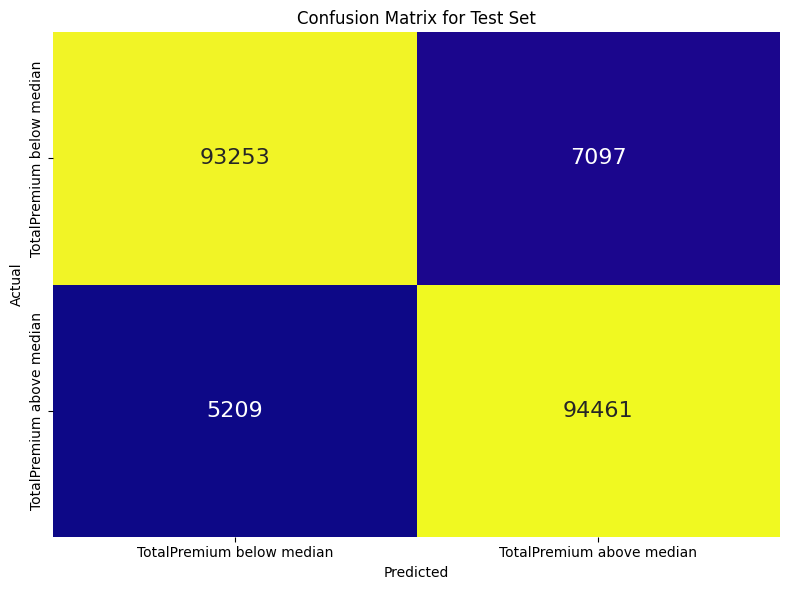

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the confusion matrix for the test set
test_cm = confusion_matrix(y_test, y_pred)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# Define class names
class_names = ['TotalPremium below median', 'TotalPremium above median']

# Plot the confusion matrix for the test set
sns.heatmap(test_cm, annot=True, fmt='d', cmap="plasma", cbar=False, ax=ax,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for Test Set')

# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
# Initialize the DecisionTreeClassifier
modelD = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
modelD.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [23]:
# evaluate the model on the test set
y_pred = modelD.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Classification Report:')
print(test_report)

Test Accuracy: 0.9894
Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    100350
           1       0.99      0.99      0.99     99670

    accuracy                           0.99    200020
   macro avg       0.99      0.99      0.99    200020
weighted avg       0.99      0.99      0.99    200020



In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost Classifier
modelXGB = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
modelXGB.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = modelXGB.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print(f'Test Accuracy (XGBoost Classifier): {test_accuracy:.4f}')
print('Test Classification Report (XGBoost Classifier):')
print(test_report)

Test Accuracy (XGBoost Classifier): 0.8267
Test Classification Report (XGBoost Classifier):
              precision    recall  f1-score   support

           0       0.92      0.72      0.81    100350
           1       0.77      0.93      0.84     99670

    accuracy                           0.83    200020
   macro avg       0.84      0.83      0.82    200020
weighted avg       0.84      0.83      0.82    200020



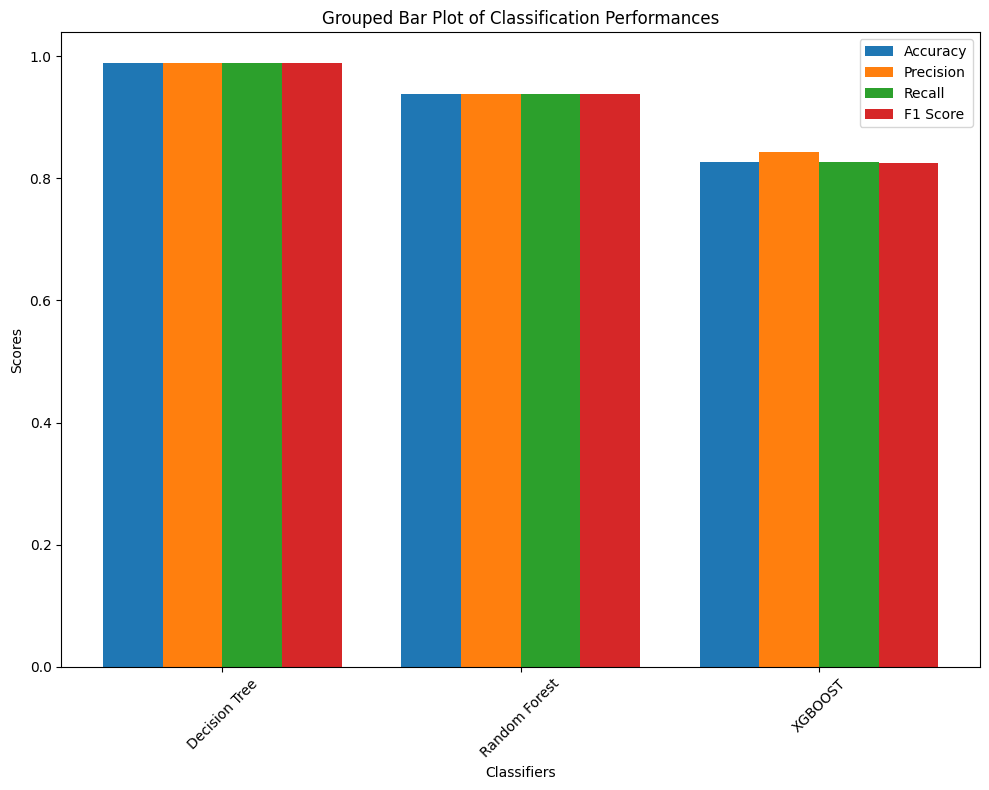

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

# List of models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    "XGBOOST" : xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Initialize a dictionary to store performance metrics
performance_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Iterate over each model to train, predict, and collect metrics
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Store metrics
    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

# Convert to numpy array for plotting
metrics_array = np.array([performance_metrics['Accuracy'],
                          performance_metrics['Precision'],
                          performance_metrics['Recall'],
                          performance_metrics['F1 Score']])

# Create the grouped bar plot
model_names = list(models.keys())
metric_names = list(performance_metrics.keys())
n_metrics = len(metric_names)
n_models = len(model_names)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define bar width and positions
bar_width = 0.2
indices = np.arange(n_models)

# Plot bars for each metric
for i, metric in enumerate(metric_names):
    ax.bar(indices + i * bar_width, metrics_array[i], bar_width, label=metric)

# Add labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Grouped Bar Plot of Classification Performances')
ax.set_xticks(indices + bar_width * (n_metrics - 1) / 2)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:


# Combine data
df_prepared = pd.concat([df_imputed, df_encoded], axis=1)

# Train-Test Split
X = df_prepared.drop(['TotalPremium', 'TotalClaims'], axis=1)
y = df['TotalPremium']  # Example target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Model Building
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred_lin)

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)

# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)

# 3. Model Evaluation
print(f'Linear Regression MSE: {lin_mse}')
print(f'Random Forest MSE: {rf_mse}')
print(f'XGBoost MSE: {xgb_mse}')

# 4. Model Interpretability with SHAP
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)